In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA       # Needed for PCA of embeddings
import os


In [44]:
P = 59
MAX = 100

# Create the dataset
# set_seed(SEED)
data = []
for i in range(MAX):
    for j in range(MAX):
        data.append([i,j,(i+j)%P])
data = np.array(data)

# Split into train and test
TRAIN_FRACTION = 0.5
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
BATCH_SIZE = 32
train_data = torch.tensor(train_data, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.long)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [45]:
D_EMBED = 128
HIDDEN = 256
P = 59

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.embed = nn.Embedding(MAX, D_EMBED)
        self.lstm = nn.LSTM(input_size=D_EMBED, hidden_size=HIDDEN, 
                             batch_first=True)
        self.linear = nn.Linear(HIDDEN, P)
        self.init_weights()

    def forward(self, x1, x2):
        x1 = self.embed(x1)
        x2 = self.embed(x2)
        x = torch.stack((x1, x2), dim=1)
        _, (h_n, _) = self.lstm(x)
        x = self.linear(h_n[-1])
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [46]:
NB_EPOCHS = 5000
LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1


# model = RNN()
model = RNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Recording
REPORT_INTERVAL = 20    # How often we print
SAVE_INTERVAL = 50      # How often we save
model_folder = 'intermediary'
# Create folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_loader:
        x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
        optimizer.zero_grad()
        output = model(x1,x2)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for batch in test_loader:
            x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
            output = model(x1,x2)
            loss = criterion(output, y) # output is 59, y is 64?
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        
    if epoch % REPORT_INTERVAL == 0:
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")
    
    if epoch % SAVE_INTERVAL == 0:
        # Save model in intermediary folder
        torch.save(model.state_dict(), f"{model_folder}/model_{epoch}.pth")
        
torch.save(model.state_dict(), f"model.pth")

0/5000: Train loss=4.0791, acc=1.4%  /  Test loss=4.0818, acc=1.2%
20/5000: Train loss=2.2358, acc=33.2%  /  Test loss=2.2992, acc=25.5%
40/5000: Train loss=1.8577, acc=46.3%  /  Test loss=1.9353, acc=35.3%
60/5000: Train loss=1.7127, acc=53.2%  /  Test loss=1.8014, acc=41.2%
80/5000: Train loss=1.6668, acc=54.4%  /  Test loss=1.7651, acc=41.0%
100/5000: Train loss=1.6500, acc=54.5%  /  Test loss=1.7429, acc=44.1%
120/5000: Train loss=1.6385, acc=55.7%  /  Test loss=1.7338, acc=41.8%
140/5000: Train loss=1.6322, acc=55.1%  /  Test loss=1.7315, acc=43.4%
160/5000: Train loss=1.6267, acc=55.8%  /  Test loss=1.7235, acc=42.0%
180/5000: Train loss=1.6211, acc=56.5%  /  Test loss=1.7190, acc=41.4%
200/5000: Train loss=1.6151, acc=56.6%  /  Test loss=1.7163, acc=42.8%
220/5000: Train loss=1.6109, acc=56.5%  /  Test loss=1.7133, acc=42.8%
240/5000: Train loss=1.6069, acc=56.3%  /  Test loss=1.7060, acc=42.8%
260/5000: Train loss=1.6063, acc=55.0%  /  Test loss=1.7076, acc=41.5%
280/5000: Trai

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f"model.pth")

## Results

Plot the evolution of accuracy and loss during training

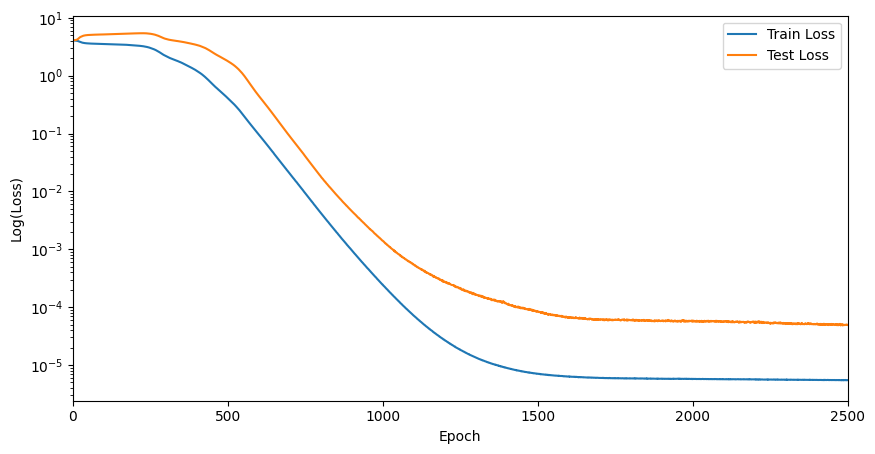

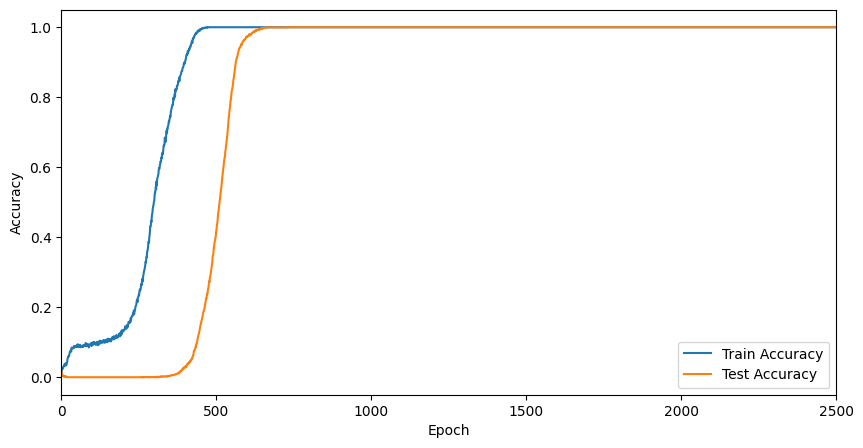

In [ ]:
NB_EPOCH_PLOT = 2500

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, NB_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.yscale('log')
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('loss_zoom.png', dpi=300)


# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, NB_EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('accuracy_zoom.png', dpi=300)